# Prior-Posterior Derived-Predictive Consistency Checks for

Post-Estimation Calculated Quantities of Interest (*QOI-Check*)

Case Study II: ANOVA Decomposition of Bivariate Spline

Holger Sennhenn-Reulen [](https://orcid.org/0000-0002-4782-4387) (Northwest German Forest Research Institute (NW-FVA))  
December 19, 2024

# Intro

Relevant parts of the code given here is inspired by the resources of the great *SBC* package ([Modrák et al., 2023](#ref-ModrakEtAl2023)) published at <https://hyunjimoon.github.io/SBC/index.html>.

Also, coding of posterior p-values is inspired by the split predictive check ([Li & Huggins, 2024](#ref-LiHuggins2024)) R code published at <https://github.com/TARPS-group/split-predictive-checks>.

## Software

We use the statistical software environment *R* ([R Core Team, 2024](#ref-RCoreTeam2024)), and R add-on packages *SBC* ([Modrák et al., 2023](#ref-ModrakEtAl2023)), *brms* ([Bürkner, 2017](#ref-Buerkner2017), [2018](#ref-Buerkner2018), [2021](#ref-Buerkner2021)), *mgcv* ([Wood, 2011](#ref-Wood2011)), *cmdstanr* ([Gabry et al., 2024](#ref-GabryEtAl2024)), *ggplot2* ([Wickham, 2016](#ref-Wickham2016)), *colorspace* ([Stauffer et al., 2009](#ref-StaufferEtAl2009)), and *future* ([Bengtsson, 2021](#ref-Bengtsson2021)).

This document is produced using *Quarto* ([Allaire et al., 2024](#ref-AllaireEtAl2024)).

# Organize R Session

In [ ]:
# setwd("~/Dropbox/forschung/simulation_based_calibration/application_D_post_estimation_calculation")
setwd("~/Dropbox/forschung/reference_grid_posterior_predictive_check/application_B_beta_beta_gaussian_additive_model")
library("mgcv")

Lade nötiges Paket: nlme

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Lade nötiges Paket: Rcpp

Loading 'brms' package (version 2.21.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attache Paket: 'brms'

Die folgenden Objekte sind maskiert von 'package:mgcv':

    s, t2

Das folgende Objekt ist maskiert 'package:stats':

    ar

This is cmdstanr version 0.8.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/hsennhenn/.cmdstan/cmdstan-2.35.0

- CmdStan version: 2.35.0


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable cmdstanr_no_ver_check=TRUE.

Load packages:

In [ ]:
library("mgcv")
library("SBC")
library("brms")
library("cmdstanr")
library("ggplot2")
library("colorspace")
library("cowplot")
library("future")

Settings:

In [ ]:
rm(list = ls())
options(brms.backend = "cmdstanr")
# Using parallel processing
plan(multisession)
options(SBC.min_chunk_size = 5)
# Setup caching of results
cache_dir <- "./SBC_cache"
if(!dir.exists(cache_dir)) {
  dir.create(cache_dir)
}

In [ ]:
rm(list = ls())
options(brms.backend = "cmdstanr")
# Using parallel processing
plan(multisession)
options(SBC.min_chunk_size = 5)
# Setup caching of results
cache_dir <- "./SBC_cache"
if(!dir.exists(cache_dir)) {
  dir.create(cache_dir)
}

Data preparation function for graphical uniformity checks:

In [ ]:
# convenient wrapper around mgcv::PredictMat
PredictMat <- function(object, data, ...) {
  data <- rm_attr(data, "terms")
  out <- mgcv::PredictMat(object, data = data, ...)
  if (length(dim(out)) < 2L) {
    # fixes issue #494
    out <- matrix(out, nrow = 1)
  }
  out
}
# convenient wrapper around mgcv::smoothCon
smoothCon <- function(object, data, ...) {
  data <- rm_attr(data, "terms")
  vars <- setdiff(c(object$term, object$by), "NA")
  for (v in vars) {
    if (is_like_factor(data[[v]])) {
      # allow factor-like variables #562
      data[[v]] <- as.factor(data[[v]])
    } else if (inherits(data[[v]], "difftime")) {
      # mgcv cannot handle 'difftime' variables
      data[[v]] <- as.numeric(data[[v]])
    }
  }
  mgcv::smoothCon(object, data = data, ...)
}
# Aid prediction from smooths represented as 'type = 2'
# code obtained from the doc of ?mgcv::smooth2random
# @param sm output of mgcv::smoothCon
# @param re output of mgcv::smooth2random
# @param data new data supplied for prediction
# @return A list of the same structure as returned by mgcv::smooth2random
s2rPred <- function(sm, re, data) {
  #sm = sm[[1]] ## for check!
  #re = hmmmm ## for check!
  #data = nd ## for check!
  # prediction matrix for new data
  X <- mgcv::PredictMat(sm, data)
  # transform to RE parameterization
  if (!is.null(re$trans.U)) {
    X <- X %*% re$trans.U
  }
  if (is.null(re$trans.D)) {
    # regression spline without penalization
    out <- list(Xf = X)
  } else {
    X <- t(t(X) * re$trans.D)
    # re-order columns according to random effect re-ordering
    X[, re$rind] <- X[, re$pen.ind != 0]
    # re-order penalization index in same way
    pen.ind <- re$pen.ind
    pen.ind[re$rind] <- pen.ind[pen.ind > 0]
    # start returning the object
    Xf <- X[, which(re$pen.ind == 0), drop = FALSE]
    out <- list(rand = list(), Xf = Xf)
    for (i in seq_along(re$rand)) {
      # loop over random effect matrices
      out$rand[[i]] <- X[, which(pen.ind == i), drop = FALSE]
      attr(out$rand[[i]], "s.label") <- attr(re$rand[[i]], "s.label")
    }
    names(out$rand) <- names(re$rand)
  }
  out
}

Data preparation function for graphical uniformity checks:

In [ ]:
## from https://github.com/TeemuSailynoja/simultaneous-confidence-bands/tree/main
dat_ecdf_diff <- function (x, variables = NULL, K = NULL, 
                           gamma = NULL, prob = 0.95, 
                           combine_variables = NULL, 
                           ecdf_alpha = NULL, ..., 
                           parameters = NULL) {
  if (!is.null(parameters)) {
    warning("The `parameters` argument is deprecated use `variables` instead.")
    if (is.null(variables)) {
      variables <- parameters
    }
  }
  ecdf_data <- data_for_ecdf_plots(x, variables = variables,
                                   prob = prob, K = K, gamma = gamma, 
                                   combine_variables = combine_variables,
                                   ecdf_alpha = ecdf_alpha, ...)
  if (ecdf_data$N < 50 && is.null(K)) {
    message("With less than 50 simulations, we recommend using plot_ecdf as it has better fidelity.\n",
            "Disable this message by explicitly setting the K parameter. ",
            "You can use the strings \"max\" (high fidelity) or \"min\" (nicer plot) or choose a specific integer.")
  }
  N <- ecdf_data$N
  K <- ecdf_data$K
  z <- ecdf_data$z
  ecdf_df <- dplyr::mutate(ecdf_data$ecdf_df, z_diff = ecdf -
                             z, type = "sample ECDF")
  limits_df_trans <- dplyr::mutate(ecdf_data$limits_df, 
                                   ymax = upper - uniform_val, 
                                   ymin = lower - uniform_val, 
                                   type = "theoretical CDF")
  return(list('ecdf_df' = ecdf_df,
              'limits_df_trans' = limits_df_trans))
}

In [ ]:
# plot_ecdf_diff_green <- function (x, variables = NULL, K = NULL, gamma = NULL, prob = 0.95, 
#                                   size = 1, alpha = 0.33, combine_variables = NULL, ecdf_alpha = NULL, 
#                                   ..., parameters = NULL) {
#   if (!is.null(parameters)) {
#     warning("The `parameters` argument is deprecated use `variables` instead.")
#     if (is.null(variables)) {
#       variables <- parameters
#     }
#   }
#   ecdf_data <- data_for_ecdf_plots(x, variables = variables, 
#                                    prob = prob, K = K, gamma = gamma, combine_variables = combine_variables, 
#                                    ecdf_alpha = ecdf_alpha, ...)
#   if (ecdf_data$N < 50 && is.null(K)) {
#     message("With less than 50 simulations, we recommend using plot_ecdf as it has better fidelity.\n", 
#             "Disable this message by explicitly setting the K parameter. ", 
#             "You can use the strings \"max\" (high fidelity) or \"min\" (nicer plot) or choose a specific integer.")
#   }
#   N <- ecdf_data$N
#   K <- ecdf_data$K
#   z <- ecdf_data$z
#   ecdf_df <- dplyr::mutate(ecdf_data$ecdf_df, z_diff = ecdf - 
#                              z, type = "sample ECDF")
#   limits_df_trans <- dplyr::mutate(ecdf_data$limits_df, ymax = upper - 
#                                      uniform_val, ymin = lower - uniform_val, type = "theoretical CDF")
#   ggplot(ecdf_df, aes(color = type, fill = type)) + 
#     geom_ribbon(data = limits_df_trans, 
#                 aes(x = x, ymax = ymax, ymin = ymin), alpha = alpha, 
#                 linewidth = size) + 
#     geom_step(aes(x = z, y = z_diff, group = variable, 
#                   alpha = alpha)) + 
#     scale_color_manual(name = "", 
#                        values = rlang::set_names(c("darkseagreen", "black"), c("theoretical CDF", "sample ECDF")), 
#                        labels = c(`theoretical CDF` = expression("Theoretical CDF"), 
#                                   `sample ECDF` = expression("Sample ECDF"))) + 
#     scale_fill_manual(name = "", values = c(`theoretical CDF` = "darkseagreen3", `sample ECDF` = "transparent"), 
#                       labels = c(`theoretical CDF` = expression("Theoretical CDF"), 
#                                  `sample ECDF` = expression("Sample ECDF"))) + 
#     scale_alpha_identity() + 
#     xlab(NULL) + 
#     ylab(NULL) + 
#     facet_wrap( ~ group, scales = "free_y")
# }

# Data Generator

In [ ]:
f_generate_y <- function(sim_df, 
                         eta, 
                         sigma) {
  sim_df$'mu_y' <- eta
  sim_df$'sigma_y' <- rep(sigma, nrow(sim_df))
  sim_df$'y' <- rnorm(n = nrow(sim_df), 
                      mean = sim_df$'mu_y', 
                      sd = sim_df$'sigma_y')
  return(sim_df)
}
f_generate_xz <- function(N, b_Intercept, phi) {
  mu <- plogis(b_Intercept)
  return(rbeta(n = N, shape1 = mu * phi, shape2 = (1 - mu) * phi))
}
f_generate_one_sim <- function(N) {
  prior_mu <- list('b_x_Intercept' = 0, 
                   'b_z_Intercept' = -1.1,
                   'b_y_Intercept' = .5,
                   'bs_y_sxz_1' = 1,
                   'bs_y_sxz_2' = -1,
                   'sds_y_sxz_1' = 1,
                   'phi_x' = 3,
                   'phi_z' = 3,
                   'sigma_y' = .1)
  prior_sd <- list('b_x_Intercept' = .001, 
                   'b_z_Intercept' = .001,
                   'b_y_Intercept' = .1,
                   'bs_y_sxz_1' = .1,
                   'bs_y_sxz_2' = .1,
                   'sds_y_sxz_1' = .1,
                   'phi_x' = .001,
                   'phi_z' = .001,
                   'sigma_y' = .01)
  b_y_Intercept <- rnorm(n = 1, 
                         mean = prior_mu$b_y_Intercept, 
                         sd = prior_sd$b_y_Intercept)
  bs_y_sxz_1 <- rnorm(n = 1, 
                      mean = prior_mu$bs_y_sxz_1, 
                      sd = prior_sd$bs_y_sxz_1)
  bs_y_sxz_2 <- rnorm(n = 1, 
                      mean = prior_mu$bs_y_sxz_2, 
                      sd = prior_sd$bs_y_sxz_2)
  sds_y_sxz_1 <- rnorm(n = 1, 
                       mean = prior_mu$sds_y_sxz_1, 
                       sd = prior_sd$sds_y_sxz_1)
  sds_y_sxz_1 <- abs(sds_y_sxz_1)
  sigma_y <- rnorm(n = 1, 
                   mean = prior_mu$sigma_y, 
                   sd = prior_sd$sigma_y)
  b_x_Intercept <- rnorm(n = 1, 
                         mean = prior_mu$b_x_Intercept, 
                         sd = prior_sd$b_x_Intercept)
  phi_x <- rnorm(n = 1, 
                 mean = prior_mu$phi_x, 
                 sd = prior_sd$phi_x)
  phi_x <- abs(phi_x)
  b_z_Intercept <- rnorm(n = 1, 
                         mean = prior_mu$b_z_Intercept, 
                         sd = prior_sd$b_z_Intercept)
  phi_z <- rnorm(n = 1, 
                 mean = prior_mu$phi_z, 
                 sd = prior_sd$phi_z)
  phi_z <- abs(phi_z)
  x <- f_generate_xz(N, b_x_Intercept, phi_x)
  z <- f_generate_xz(N, b_z_Intercept, phi_z)
  dat_xz <- data.frame('x' = x, 'z' = z)
  sm <- mgcv::smoothCon(object = s(x, z, k = 10), data = dat_xz,
                        absorb.cons = TRUE, modCon = 3, diagonal.penalty = TRUE)
  sm2r <- mgcv::smooth2random(object = sm[[1]], vnames = c('x', 'z'), type = 2)
  Xf <- sm2r[['Xf']]
  Xr <- sm2r[['rand']][['Xr']]
  s_y_sxz <- t(MASS::mvrnorm(n = 1, mu = rep(0, ncol(Xr)), 
                             Sigma = sds_y_sxz_1 * diag(ncol(Xr))))
  variables <- list('b_y_Intercept' = b_y_Intercept, 
                    'bs_y_sxz_1' = bs_y_sxz_1, 
                    'bs_y_sxz_2' = bs_y_sxz_2,
                    'sds_y_sxz_1' = sds_y_sxz_1,
                    's_y_sxz[1]' = s_y_sxz[1, 1], 
                    's_y_sxz[2]' = s_y_sxz[1, 2], 
                    's_y_sxz[3]' = s_y_sxz[1, 3],
                    's_y_sxz[4]' = s_y_sxz[1, 4],
                    's_y_sxz[5]' = s_y_sxz[1, 5],
                    's_y_sxz[6]' = s_y_sxz[1, 6],
                    's_y_sxz[7]' = s_y_sxz[1, 7],
                    'sigma_y' = sigma_y,
                    'b_x_Intercept' = b_x_Intercept, 
                    'b_z_Intercept' = b_z_Intercept,
                    'phi_x' = phi_x,
                    'phi_z' = phi_z)
  etaf <- Xf %*% c(bs_y_sxz_1, bs_y_sxz_2)
  etar <- Xr %*% t(s_y_sxz)
  eta <- b_y_Intercept + etaf + etar
  return(list('variables' = variables,
              'generated' = f_generate_y(sim_df = dat_xz, 
                                         eta = eta, 
                                         sigma = sigma_y)))
}
f_generate_n_sims <- SBC_generator_function(f_generate_one_sim, 
                                            N = 1000)
set.seed(123)
datasets <- generate_datasets(f_generate_n_sims, 20)
head(datasets$generated[[1]])

          x           z      mu_y   sigma_y          y
1 0.6428125 0.471219239 0.3496019 0.1012929 0.33045945
2 0.1542820 0.158118671 0.1796588 0.1012929 0.10296001
3 0.3846568 0.116883626 0.1478711 0.1012929 0.22810111
4 0.3718601 0.228222288 0.2942474 0.1012929 0.43050453
5 0.4644184 0.003815211 0.1276784 0.1012929 0.05732729
6 0.6761364 0.082005730 1.0524761 0.1012929 1.00740764

In [ ]:
# cowplot::plot_grid(ggplot(data = subset(datasets$generated[[1]], w_y > .5), 
#                           aes(x = x, y = z, color = y)) + 
#                      geom_point() + 
#                      colorspace::scale_color_continuous_divergingx() + 
#                      theme(legend.position = "top"),
#                    ggplot(data = subset(datasets$generated[[2]], w_y > .5), 
#                           aes(x = x, y = z, color = y)) + 
#                      geom_point() + 
#                      colorspace::scale_color_continuous_divergingx() + 
#                      theme(legend.position = "top"),
#                    ggplot(data = subset(datasets$generated[[3]], w_y > .5), 
#                           aes(x = x, y = z, color = y)) + 
#                      geom_point() + 
#                      colorspace::scale_color_continuous_divergingx() + 
#                      theme(legend.position = "top"),
#                    ggplot(data = subset(datasets$generated[[4]], w_y > .5), 
#                           aes(x = x, y = z, color = y)) + 
#                      geom_point() + 
#                      colorspace::scale_color_continuous_divergingx() + 
#                      theme(legend.position = "top"))
# priors <- 
#   prior(normal(.5,.1), class = "Intercept", resp = "y") + 
#   prior(normal(.1,.01), class = "sigma", resp = "y")
# frmla <- bf(n | weights(w_n) ~ t2(x, z), family = poisson(link = "log")) + 
#   bf(y | weights(w_y) ~ t2(x, z), family = gaussian())

# Backend

In [ ]:
# m <- brm(frmla,
#          prior = priors, 
#          chains = 1,
#          data = datasets$generated[[1]], 
#          backend = "cmdstanr")
# plot(m, nvariables = 7)
# summary(m)

In [ ]:
priors <- prior(normal(.5,.1), class = "Intercept", resp = "y") +
  prior(normal(1,.1), class = "b", coef = "sxz_1", resp = "y") +
  prior(normal(-1,.1), class = "b", coef = "sxz_2", resp = "y") +
  prior(normal(1,.1), class = "sds", resp = "y") +
  prior(normal(.1,.01), class = "sigma", resp = "y") +
  prior(normal(0,.001), class = "Intercept", resp = "x") +
  prior(normal(-1.1,.001), class = "Intercept", resp = "z") +
  prior(normal(3,.001), class = "phi", resp = "x") +
  prior(normal(3,.001), class = "phi", resp = "z")
frmla <- bf(x ~ 1, family = Beta(link = "logit")) +
  bf(z ~ 1, family = Beta(link = "logit")) +
  bf(y ~ s(x, z, k = 10), family = gaussian())
f_backend <- SBC_backend_brms(frmla,
                              prior = priors, 
                              chains = 1,
                              iter = 2000,
                              template_data = datasets$generated[[1]],
                              out_stan_file = file.path(cache_dir, 
                                                               "case_study_II.stan"))

Setting 'rescor' to FALSE by default for this model

In [ ]:
set.seed(0)
results <- compute_SBC(datasets = datasets, 
                       backend = f_backend, 
                       cache_mode = "results", 
                       cache_location = file.path(cache_dir,
                                                        "SBC_results_case_study_II"))

Results loaded from cache file 'SBC_results_case_study_II'

 - 7 (35%) fits had at least one Rhat > 1.01. Largest Rhat was 2.124.

 - 2 (10%) fits had tail ESS undefined or less than half of the maximum rank, potentially skewing 
the rank statistics. The lowest tail ESS was 11.
 If the fits look good otherwise, increasing `thin_ranks` (via recompute_SBC_statistics) 
or number of posterior draws (by refitting) might help.

 - 1 (5%) fits had divergent transitions. Maximum number of divergences was 753.

 - 2 (10%) fits had iterations that saturated max treedepth. Maximum number of max treedepth was 999.

 - 1 (5%) fits had low BFMI.

 - 20 (100%) fits had some steps rejected. Maximum number of rejections was 13.

Not all diagnostics are OK.
You can learn more by inspecting $default_diagnostics, $backend_diagnostics 
and/or investigating $outputs/$messages/$warnings for detailed output from the backend.

# Visualize bivariate smooth at first four simulation runs

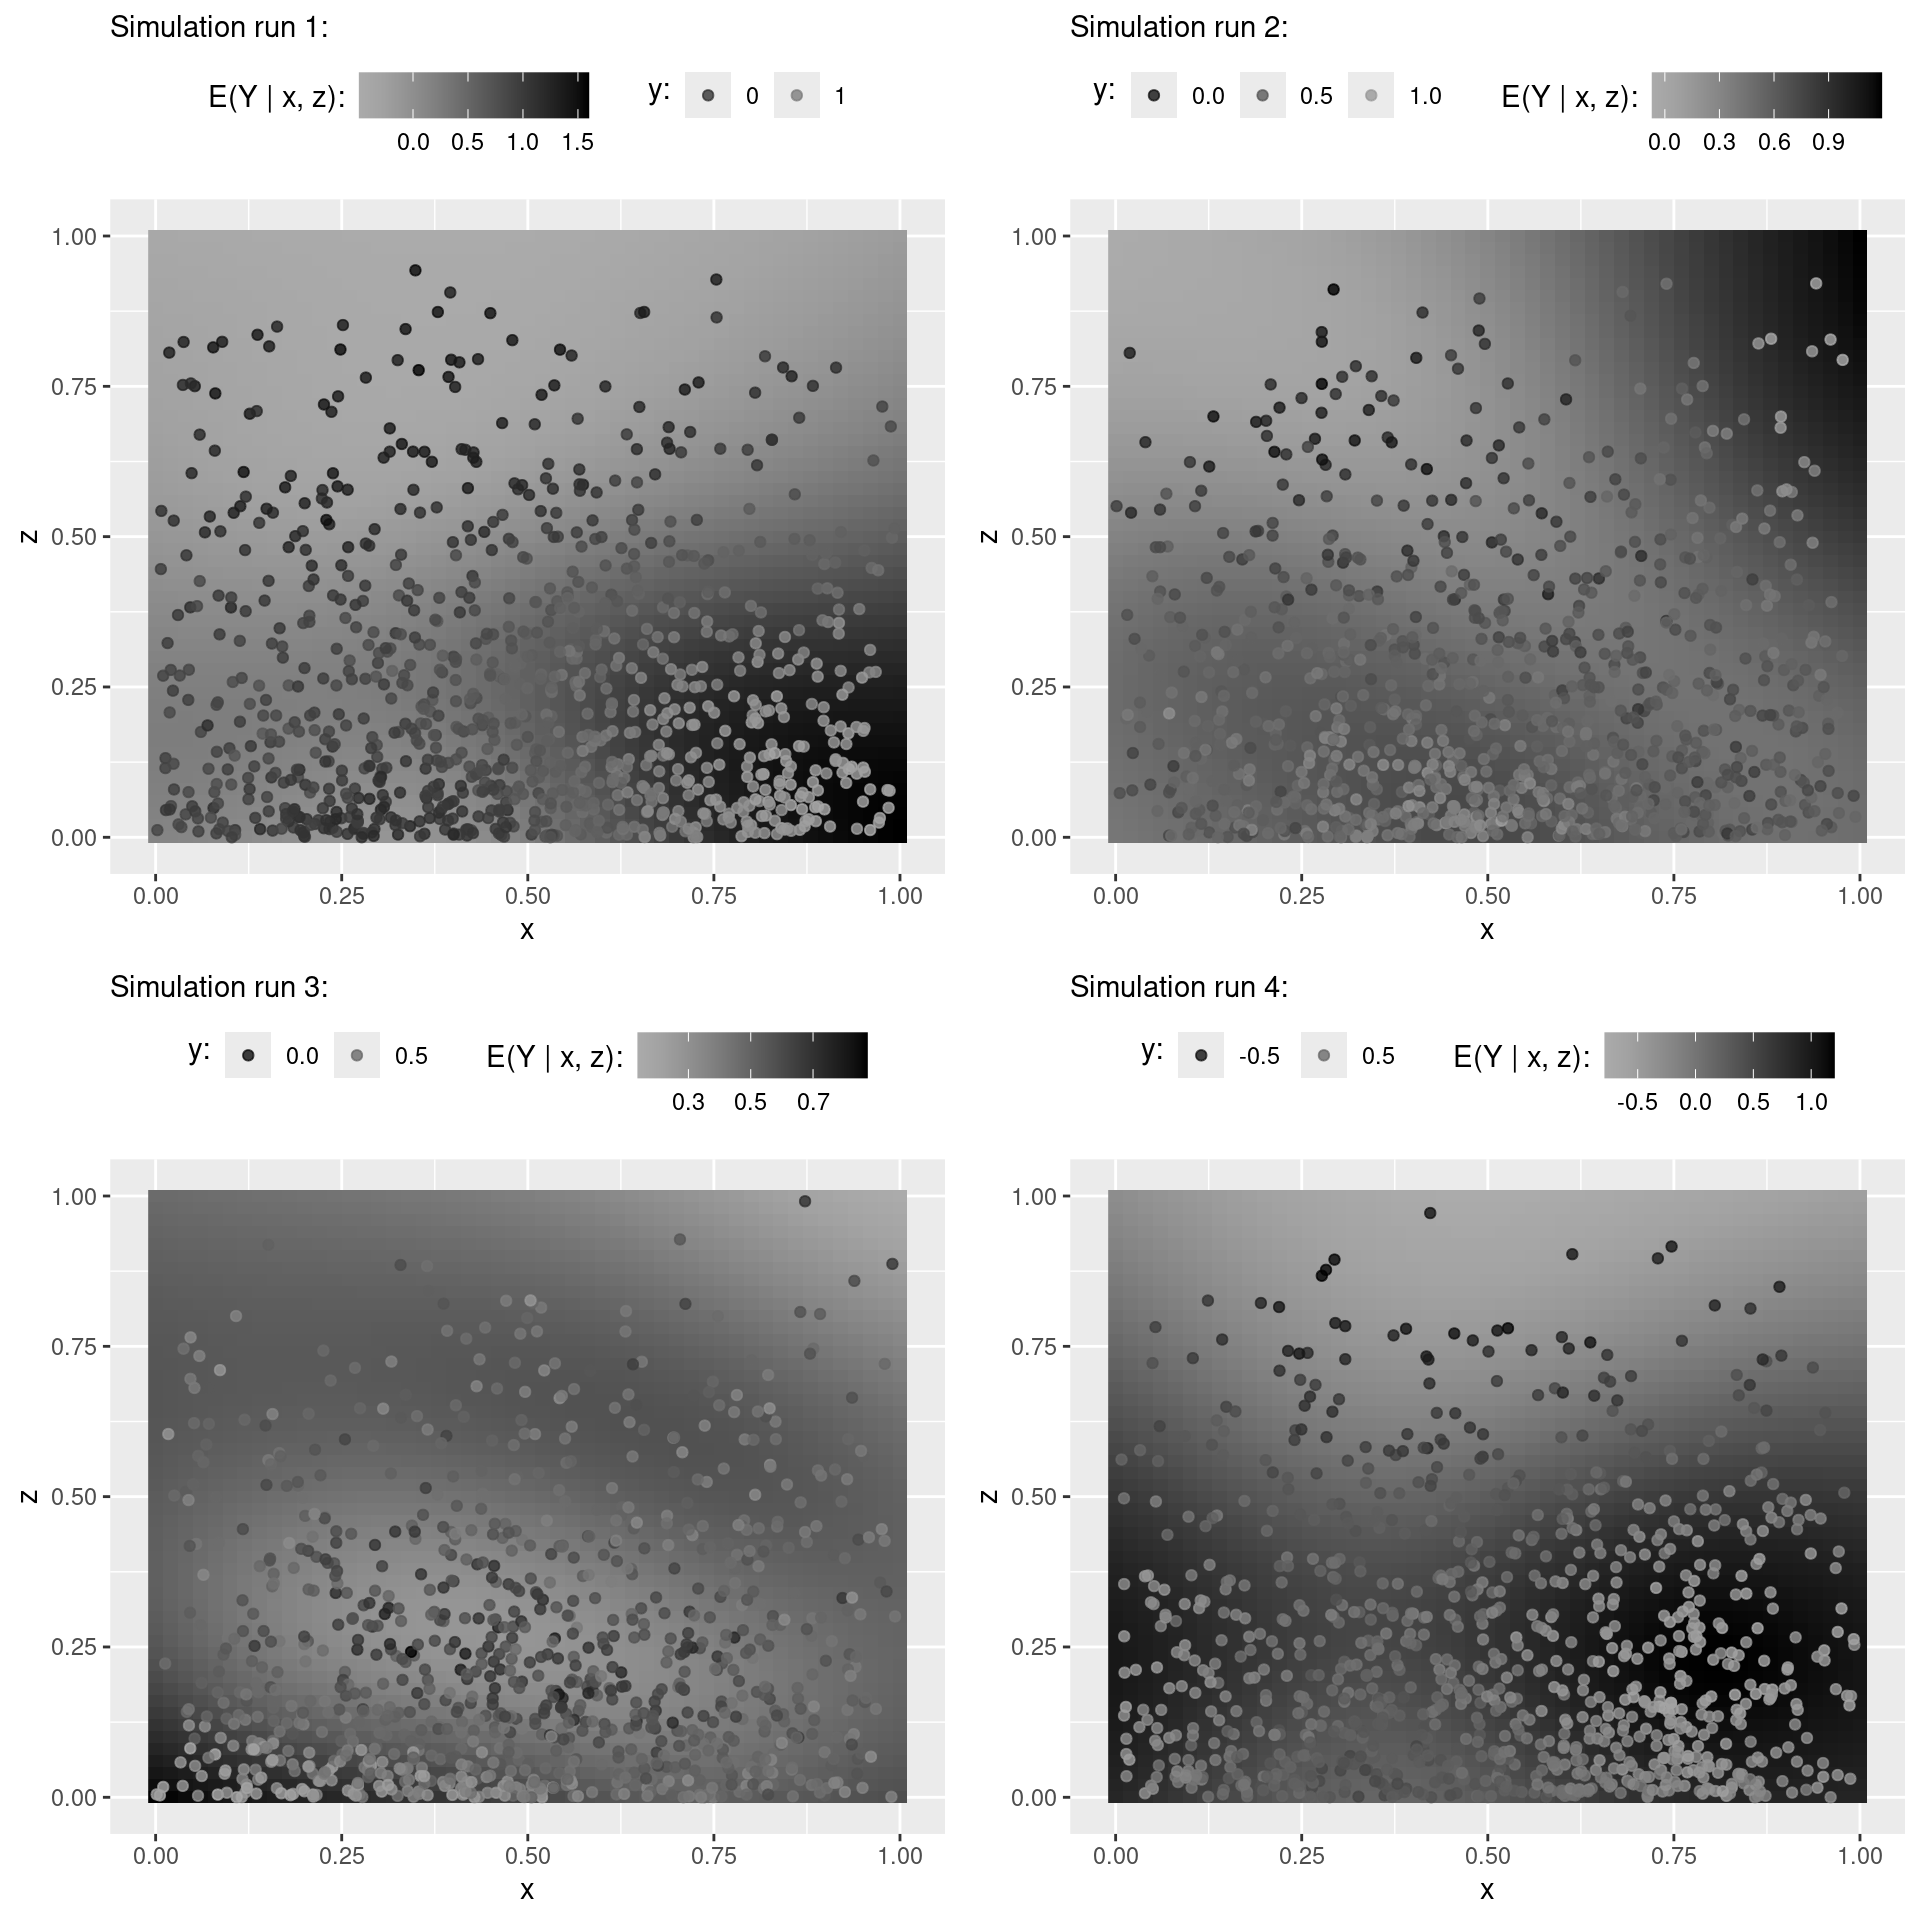

In [ ]:
nd <- expand.grid('x' = seq(0, 1, by = .02), 'z' = seq(0, 1, by = .02))
p_list <- vector("list", 4)
for (r in 1:4) {
  m <- results$fits[[r]]
  fit <- fitted(object = m, newdata = nd)
  nd$fit_y <- fit[, 'Estimate', 'y']
  p_list[[r]] <- ggplot(data = nd, aes(x = x, y = z)) + 
    geom_raster(aes(fill = fit_y)) + 
    scale_fill_continuous_sequential(pal = "Grays", l1 = 0, l2 = 70) +
    geom_point(data = m$data, aes(color = y), alpha = .8) + 
    scale_color_continuous_sequential(breaks = scales::breaks_extended(n = 3), 
                                      pal = "Grays", l1 = 0, l2 = 70, rev = FALSE) +
    # colorspace::scale_color_continuous_sequential(pal = "Rocket") +
    guides(color = guide_legend(nrow = 1)) +
    labs(color = "y:", fill = "E(Y | x, z):", 
         subtitle = paste0("Simulation run ", r, ":")) +
    theme(legend.position = 'top') +
    theme(legend.title = element_text(vjust = .8))
}
cowplot::plot_grid(plotlist = p_list, ncol = 2)

In [ ]:
pdf("20241219_case_study_II_bivariate_smooth_r1to4.pdf", 
    height = 10, width = 10)
cowplot::plot_grid(plotlist = p_list, ncol = 2)
invisible(dev.off())

In [ ]:
# results <- readRDS(file = "./SBC_cache/SBC_results_case_study_II.rds")
# tmp <- results$result$fits[[1]]
# tmp <- as.matrix(tmp)
# colnames(tmp)

In [ ]:
# results$backend_diagnostics
# summary(results$fits[[1]])
# summary(results$fits[[2]])
# summary(results$fits[[3]])
# summary(results$fits[[4]])
# summary(results$fits[[5]])
# 
# plot(results$fits[[1]], nvariables = 7)
# plot(results$fits[[2]], nvariables = 7)
# plot(results$fits[[3]], nvariables = 7)
# 
# plot(results$fits[[2]], nvariables = 7)
# as.data.frame(datasets$variables)[2, ]
# 
# summary(results$fits[[3]])
# summary(results$fits[[4]])
# summary(results$fits[[5]])

# QOI-Check

In [ ]:
f_postprocessing <- function(m, b, focus_on = 'x', at = .8, 
                             integration_grid = seq(.025, .975, by = .05)) {
  if (!(focus_on %in% c('x', 'z'))) {
    stop("'focus_on' must be either 'x' or 'z'.")
  }
  nd <- data.frame('variable1' = at)
  nd <- as.data.frame(expand.grid('variable1' = nd$variable1, 
                                  'variable2' = integration_grid))
  names(nd) <- c('x', 'z')
  fit <- fitted(m, newdata = nd, dpar = "mu", summary = F)
  if (focus_on == 'x') {
    phi <- fitted(m, newdata = nd, resp = "z", dpar = "phi", summary = F)
    shape1 <- fit[, , "z"] * phi
    shape2 <- (1 - fit[, , "z"]) * phi
    d <- shape1 * 0
    for (i in 1:nrow(nd)) {
      d[, i] <- dbeta(x = nd$z[i], shape1 = shape1[, i], shape2 = shape2[, i])
    }
  }
  if (focus_on == 'z') {
    phi <- fitted(m, newdata = nd, resp = "x", dpar = "phi", summary = F)
    shape1 <- fit[, , "x"] * phi
    shape2 <- (1 - fit[, , "x"]) * phi
    d <- shape1 * 0
    for (i in 1:nrow(nd)) {
      d[, i] <- dbeta(x = nd$x[i], shape1 = shape1[, i], shape2 = shape2[, i])
    }
  }
  d <- d / apply(d, MAR = 1, FUN = sum)
  tmp <- abs(apply(d, MAR = 1, FUN = sum) - 1)
  if (any(tmp > 1e-10)) {
    stop("No proper calculation of weights!")
  }
  return(list('Weighted' = apply(d * fit[, , 'y'], MAR = 1, FUN = sum), 
              'Unweighted' = apply(fit[, , 'y'], MAR = 1, FUN = mean)))
}
ranks_rgpp <- NULL
for (j in 1:20) {
  cat(paste0("j = ", j, ":\n"))
  cat("  f_postprocessing_fast():\n")
  cat("  ")
  res <- all_weighted <- NULL
  x_grid <- seq(.025, .975, by = .05)
  for (i in 1:length(x_grid)) {
    x <- x_grid[i]
    tmp <- f_postprocessing(results$fits[[j]], 
                            as.data.frame(datasets$variables)[j, ], 
                            focus_on = 'x', x, 
                            seq(.0005, .9995, by = .001))
    all_weighted <- cbind(all_weighted, tmp[['Weighted']])
    for (method in c('Weighted', 'Unweighted')) {
      res <- rbind(res, 
                   data.frame('x' = x, 
                              'y' = mean(tmp[[method]]), 
                              'method' = method, 
                              'stat' = 'Mean'))
      res <- rbind(res, 
                   data.frame('x' = x, 
                              'y' = median(tmp[[method]]), 
                              'method' = method, 
                              'stat' = 'Median'))
      res <- rbind(res, 
                   data.frame('x' = x, 
                              'y' = quantile(tmp[[method]], probs = .025), 
                              'method' = method, 
                              'stat' = '2.5% quantile'))
      res <- rbind(res, 
                   data.frame('x' = x, 
                              'y' = quantile(tmp[[method]], probs = .975), 
                              'method' = method, 
                              'stat' = '97.5% quantile'))
    }
    cat(".")
  }
  res0 <- res
  ## Compare to GAM s() + s() + ti()
  ## https://cran.r-project.org/web/packages/mgcv/mgcv.pdf
  ## p. 79:
  ## "Sometimes it is interesting to specify smooth models with a main 
  ##  effects + interaction structure such as
  ##  E(yi) = f1(xi) + f2(zi) + f3(xi, zi)
  ##  [...]
  ##  for example. 
  ##  Such models should be set up using ti terms in the model formula. 
  ##  For example:
  ##  y ~ ti(x) + ti(z) + ti(x,z), 
  ##  [...]
  ##  The ti terms produce interactions with the component main effects 
  ##  excluded appropriately. (There is in fact no need to use ti terms 
  ##  for the main effects here, s terms could also be used.)"                                                        ## "[...] in fact no need to use ti terms for the main effects here, 
  ##  s terms could also be used."
  m_gam <- gam(y ~ s(x) + s(z) + ti(x, z), data = datasets$generated[[j]])
  nd <- data.frame(x = x_grid, z = x_grid)
  tmp <- predict(m_gam, type = "terms", newdata = nd)
  res <- rbind(res, 
               data.frame(x = x_grid, 
                          y = tmp[, 's(x)'] + coef(m_gam)[1], 
                          method = "mgcv::gam: s(x) [model: y ~ s(x) + s(z) + ti(x, z)]", 
                          stat = "Effect"))
  ## ############################################
  ## Reference grid posterior predictive check ##
  ## ############################################
  cat("\n")
  cat("  reference grid prior prediction:\n")
  cat("  ")
  x_grid <- seq(.025, .975, by = .05)
  ref_grid_prior_mean_y_x <- rep(NA, length(x_grid))
  for (i in 1:length(x_grid)) {
    b <- as.data.frame(datasets$variables)[j, ]
    z <- f_generate_xz(N = 10000, 
                       b_Intercept = as.numeric(b['b_z_Intercept']), 
                       phi = as.numeric(b['phi_z']))
    dat_xz <- data.frame('x' = x_grid[i], 'z' = z)
    sm <- mgcv::smoothCon(object = s(x, z, k = 10), data = results$fits[[j]]$data,
                          absorb.cons = TRUE, modCon = 3, diagonal.penalty = TRUE)
    sm2r <- mgcv::smooth2random(object = sm[[1]], vnames = c('x', 'z'), type = 2)
    sm2r_pre <- s2rPred(sm = sm[[1]], re = sm2r, data = dat_xz)
    Xf <- sm2r_pre[['Xf']]
    Xr <- sm2r_pre[['rand']][['Xr']]
    etaf <- Xf %*% as.numeric(b[grep(names(b), pattern = "bs_", fixed = T)])
    etar <- Xr %*% as.numeric(b[grep(names(b), pattern = "s_y_sxz[", fixed = T)])
    eta <- as.numeric(b['b_y_Intercept']) + etaf + etar
    dat_xz <- f_generate_y(dat_xz, as.numeric(eta), as.numeric(b["sigma_y"]))
    ref_grid_prior_mean_y_x[i] <- mean(dat_xz$y)
    cat(".")
  }
  cat("\n")
  res <- rbind(res, 
               data.frame(x = x_grid, 
                          y = ref_grid_prior_mean_y_x,
                          method = "Reference grid prior prediction (N = 1000)", 
                          stat = "Mean"))
  res$stat <- factor(res$stat, levels = c("Mean", "Median", "2.5% quantile", 
                                          "97.5% quantile", "Effect"))
  if (j == 1) {
  p <- ggplot(data = subset(res, stat != "Median"), aes(x = x, y = y)) + 
    geom_line(aes(group = paste0(stat, method), 
                  linetype = stat)) + #, color = method
    theme(legend.position = "top", legend.box="vertical", legend.margin=margin()) +
    guides(color = "none") +
    scale_linetype_manual(values = c(1, 3, 3, 2)) +
    facet_wrap(~ method) +
    labs(color = "Method:", linetype = "Statistic:")
  }
  rgpp_all_weighted <- rbind(subset(res, 
                           method == "reference grid prior prediction (N = 1000)")$y, 
                           all_weighted)
  ranks_rgpp <- cbind(ranks_rgpp, 
                      apply(rgpp_all_weighted, MAR = 2, 
                            FUN = function(x){mean(x[-1] > x[1])}))
}
ranks <- data.frame('rank' = reshape2::melt(ranks_rgpp)$value, 
                    'max_rank' = 1,
                    'variable' = reshape2::melt(ranks_rgpp)$Var1,
                    'sim_id' = reshape2::melt(ranks_rgpp)$Var2)
ranks$rank <- ranks$rank * 1000
ranks$rank <- ranks$rank - 1 + runif(nrow(ranks))
ranks$max_rank <- ranks$max_rank * 1000
ranks$variable <- factor(paste("x:", x_grid[ranks$variable]), 
                         levels = paste("x:", x_grid))

In [ ]:
#save(ranks, file = "20241218_ranks.RData")
# save(p, file = "20241218_p.RData")
load(file = "20241218_ranks.RData")

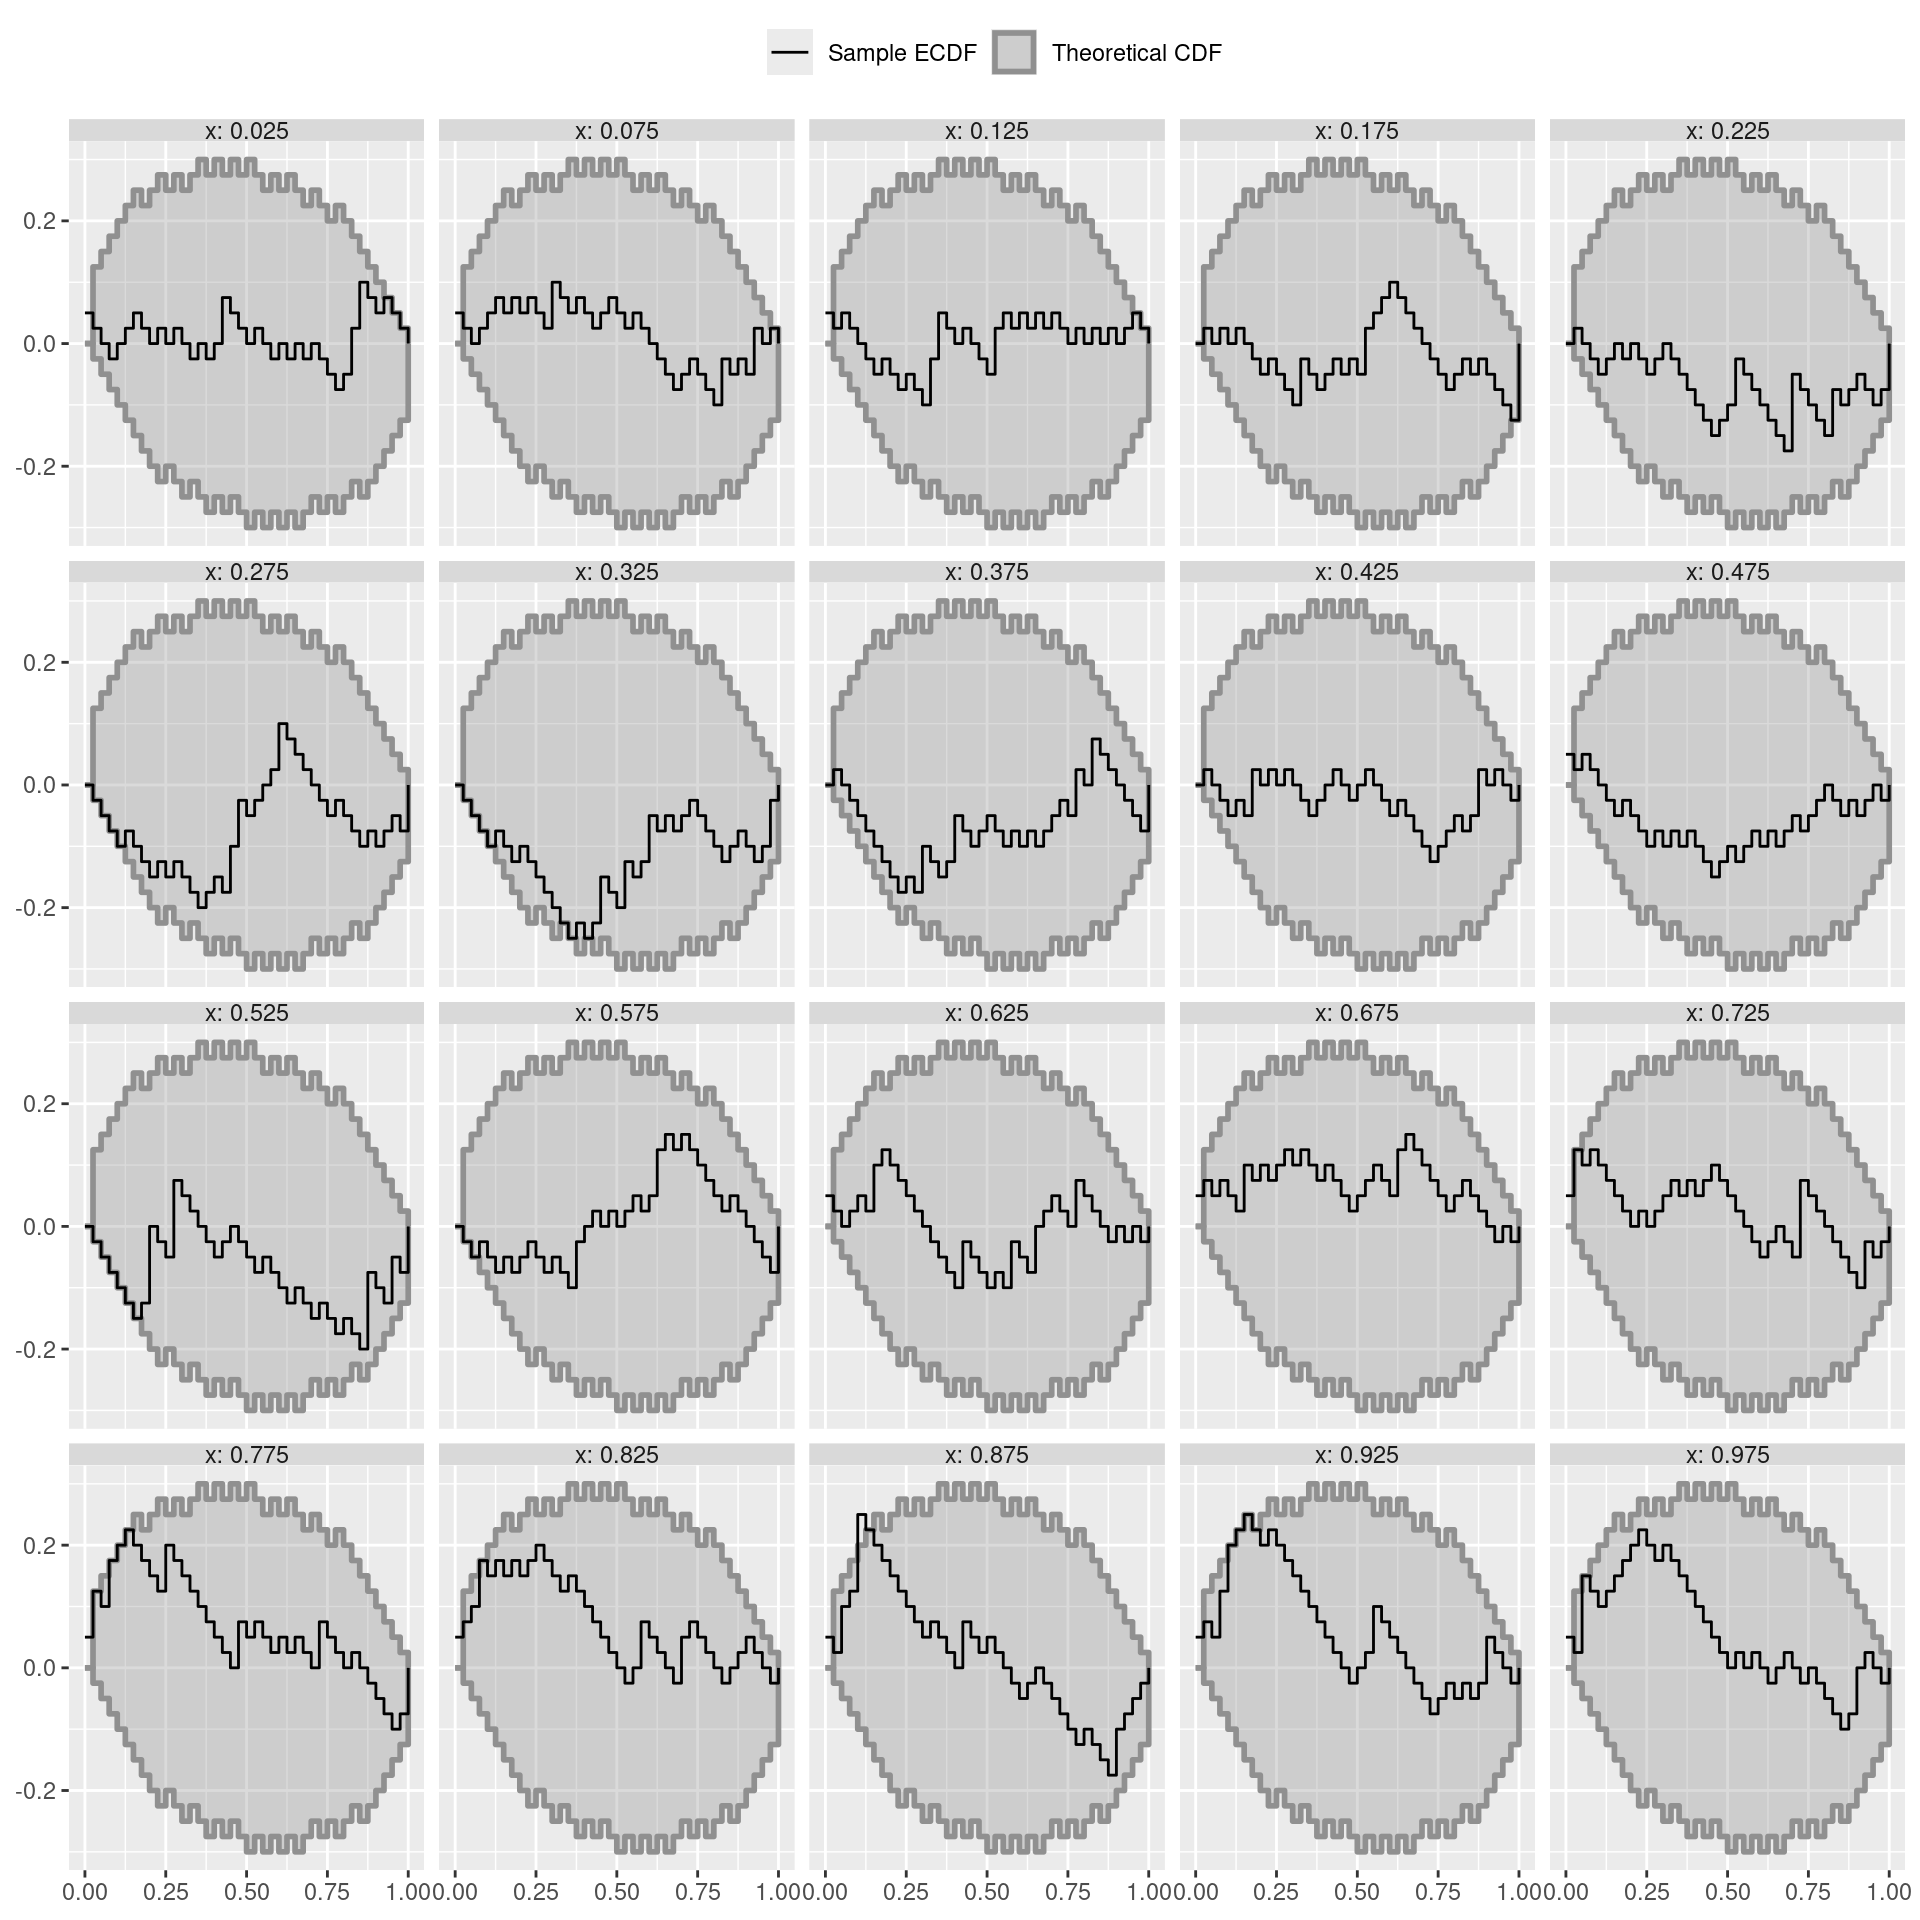

In [ ]:
tmp <- dat_ecdf_diff(ranks, variables = levels(ranks$variable), K = 40)
col_color <- c(colorspace::sequential_hcl(n = 20, pal = "Grays")[10], "black")
col_fill <- c(colorspace::sequential_hcl(n = 20, pal = "Grays")[10], "black")
names(col_color) <- names(col_fill) <- 
    c("theoretical CDF", "sample ECDF")
l <- c('theoretical CDF' = expression("Theoretical CDF"), 
       'sample ECDF' = expression("Sample ECDF"))
ggplot(tmp$ecdf_df, aes(color = type, fill = type)) + 
  geom_ribbon(data = tmp$limits_df_trans, 
              aes(x = x, ymax = ymax, ymin = ymin), alpha = .33, 
              linewidth = 1) + 
  geom_step(aes(x = z, y = z_diff, group = variable)) + 
  scale_color_manual(name = "", values = col_color, labels = l) + 
  scale_fill_manual(name = "", values = col_fill, labels = l) + 
  scale_alpha_identity() + 
  xlab(NULL) + 
  ylab(NULL) + 
  facet_wrap(~variable) +
  theme(strip.text = element_text(margin = margin(b = 0, t = 0))) +
  theme(legend.position = "top")

In [ ]:
pdf("20241219_results_QOI_check_case_study_II.pdf", 
    height = 10, width = 13)
ggplot(tmp$ecdf_df, aes(color = type, fill = type)) + 
  geom_ribbon(data = tmp$limits_df_trans, 
              aes(x = x, ymax = ymax, ymin = ymin), alpha = .33, 
              linewidth = 1) + 
  geom_step(aes(x = z, y = z_diff, group = variable)) + 
  scale_color_manual(name = "", values = col_color, labels = l) + 
  scale_fill_manual(name = "", values = col_fill, labels = l) + 
  scale_alpha_identity() + 
  xlab(NULL) + 
  ylab(NULL) + 
  facet_wrap(~variable) +
  theme(strip.text = element_text(margin = margin(b = 0, t = 0))) +
  theme(legend.position = "top")
invisible(dev.off())
# head(datasets$generated[[1]])
# ggplot(data = datasets$generated[[1]], 
#        aes(x = x, y = z, fill = y)) + 
#   geom_tile()

# Visualise ‘isolated effect’ of `x` for 1st simulation run

In [ ]:
load(file = "20241218_p.RData")

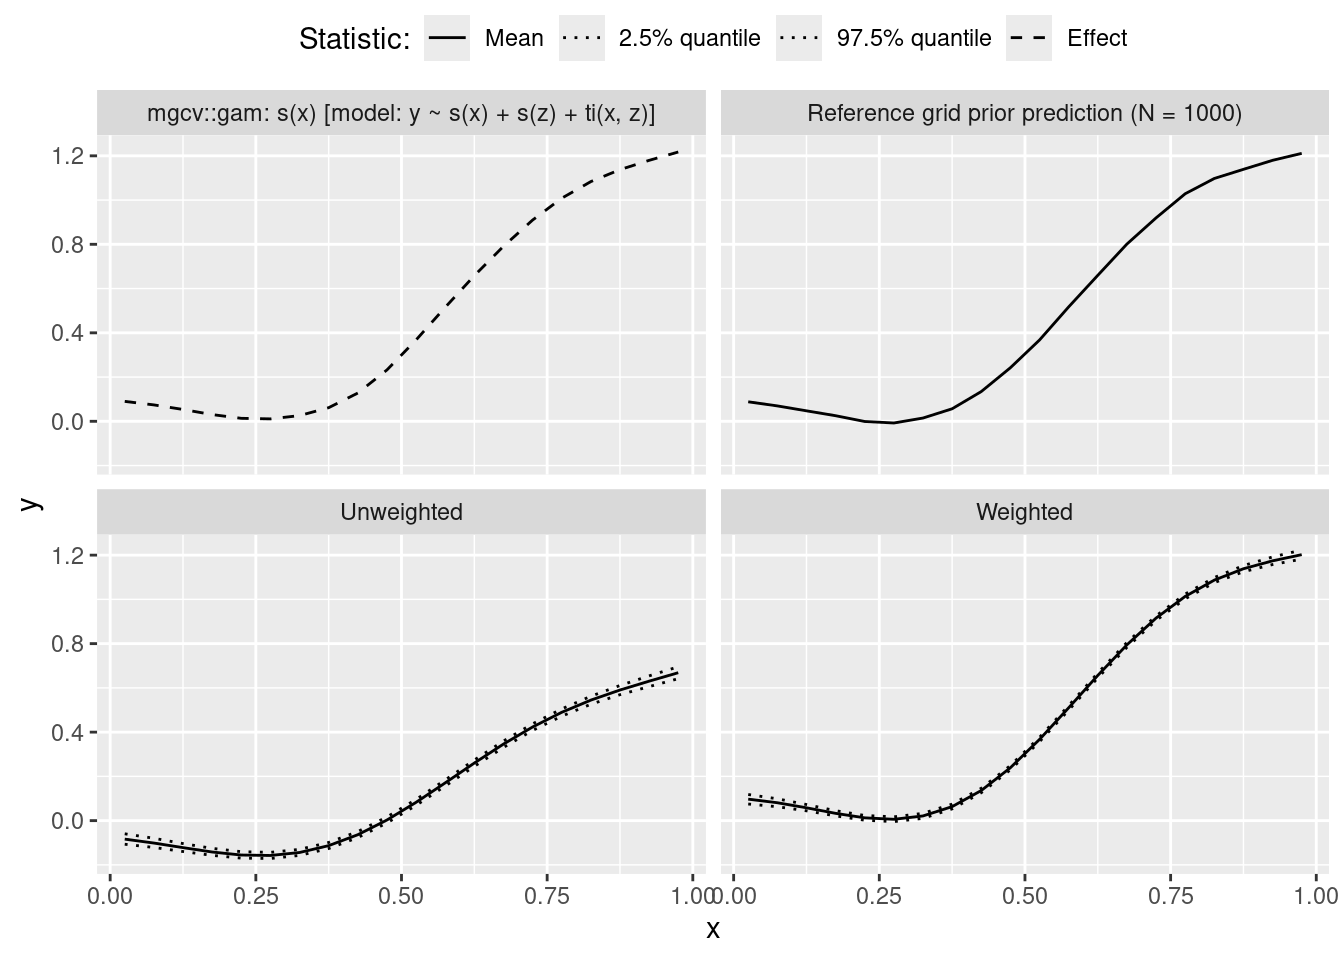

In [ ]:
print(p)

In [ ]:
pdf("20241219_isolated_x_effect_case_study_II.pdf", 
    height = 10, width = 13)
ggplot(tmp$ecdf_df, aes(color = type, fill = type)) + 
  geom_ribbon(data = tmp$limits_df_trans, 
              aes(x = x, ymax = ymax, ymin = ymin), alpha = .33, 
              linewidth = 1) + 
  geom_step(aes(x = z, y = z_diff, group = variable)) + 
  scale_color_manual(name = "", values = col_color, labels = l) + 
  scale_fill_manual(name = "", values = col_fill, labels = l) + 
  scale_alpha_identity() + 
  xlab(NULL) + 
  ylab(NULL) + 
  facet_wrap(~variable) +
  theme(strip.text = element_text(margin = margin(b = 0, t = 0))) +
  theme(legend.position = "top")
invisible(dev.off())

Allaire, J. J., Teague, C., Scheidegger, C., Xie, Y., & Dervieux, C. (2024). *Quarto (Version 1.4.553)*. <https://doi.org/10.5281/zenodo.5960048>

Bengtsson, H. (2021). A unifying framework for parallel and distributed processing in r using futures. *The R Journal*, *13*(2), 208–227. <https://doi.org/10.32614/RJ-2021-048>

Bürkner, P.-C. (2017). <span class="nocase">brms</span>: An R package for Bayesian multilevel models using Stan. *Journal of Statistical Software*, *80*(1), 1–28. <https://doi.org/10.18637/jss.v080.i01>

Bürkner, P.-C. (2018). Advanced Bayesian multilevel modeling with the R package <span class="nocase">brms</span>. *The R Journal*, *10*(1), 395–411. <https://doi.org/10.32614/RJ-2018-017>

Bürkner, P.-C. (2021). Bayesian item response modeling in R with <span class="nocase">brms</span> and Stan. *Journal of Statistical Software*, *100*(5), 1–54. <https://doi.org/10.18637/jss.v100.i05>

Gabry, J., Češnovar, R., Johnson, A., & Bronder, S. (2024). *Cmdstanr: R interface to ’CmdStan’*. <https://mc-stan.org/cmdstanr/>

Li, J., & Huggins, J. H. (2024). *Calibrated model criticism using split predictive checks*. <https://arxiv.org/abs/2203.15897>

Modrák, M., Moon, A. H., Kim, S., Bürkner, P., Huurre, N., Faltejsková, K., Gelman, A., & Vehtari, A. (2023). Simulation-based calibration checking for bayesian computation: The choice of test quantities shapes sensitivity. *Bayesian Analysis*, *Advance publication*. <https://doi.org/10.1214/23-BA1404>

R Core Team. (2024). *R: A Language and Environment for Statistical Computing (Version 4.4.1)*. R Foundation for Statistical Computing.

Stauffer, R., Mayr, G. J., Dabernig, M., & Zeileis, A. (2009). Somewhere over the rainbow: How to make effective use of colors in meteorological visualizations. *Bulletin of the American Meteorological Society*, *96*(2), 203–216. <https://doi.org/10.1175/BAMS-D-13-00155.1>

Wickham, H. (2016). *ggplot2: Elegant graphics for data analysis*. Springer-Verlag New York. <https://ggplot2.tidyverse.org>

Wood, S. N. (2011). Fast stable restricted maximum likelihood and marginal likelihood estimation of semiparametric generalized linear models. *Journal of the Royal Statistical Society (B)*, *73*(1), 3–36.